## Astro 330 "Computational Astrophysics"

### Homework 4. Monte Carlo methods (40 points)

### Distributed 28 October; due Thursday, Nov 4, 7pm. 

### 1. Implementing the affine-invariant MCMC sampler of Goodman & Weare (2010) (15 points)

<a href="http://msp.org/camcos/2010/5-1/p04.xhtml">Goodman & Weare 2010</a> have developed an MCMC ensemble sampling algorithm (i.e., algorithm producing multiple MCMC chains at the same time) that is almost as simple as the original Metropolis algorithm, but which is much more efficient in general and have considerably smaller auto-correlation lengths for the same distribution than Metropolis. It is also much more fool-proof and is not very sensitive to parameters such as initial distribution of walkers and step size. It is particularly efficient for distributions that exhibit strong degeneracies (narrow ridges in the pdf), such as the Rosenbrock density pdf, often encountered in statistical inference when parameters are highly correlated. This becomes more and more severe for posterior distributions in larger number of dimensions. The Goodman & Weare (2010) algorithm was implemented in the <a href="http://dan.iel.fm/emcee/current/">emcee code</a> by Dan Foreman-Mackey and collaborators and this code is now in wide-spread usage in astronomy (some of you probably used it). As you will see in this exercise, you don't really need to rely on a package (except perhaps when speed is a serious issue) because you can write a short routine of your own, which will do the job. You will be using your MCMC code developed in this homework in the next homework to do real-life statistical inference calculations. 



In [1]:
from __future__ import division
from math import cos
import numpy as np
from time import time
from time import clock
import string
import sys
import time
import pandas
from codes.plot_utils import plot_pretty
from matplotlib import pylab as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Polygon
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
#from mpi4py import MPI as mpi
from colossus.cosmology import cosmology
from codes.setup import data_home_dir
#from mpl_toolkits.basemap import Basemap

from numpy import random as rnd
from codes.plot_utils import plot_pretty, plot_2d_dist

In this method, one usually initializes a number of walkers distributed with a multi-variate Gaussian probability around a best  starting point or according to a prior pdf. Then MCMC chain is constructed in a way similar to the Metropolis algorithm: proposing a step, estimating probability at the proposed location, and then accepting the step with an acceptance probability. The difference from Metropolis is in the way the step is proposed and how acceptance probability is calculated (see S 2 of GW10 for more details and for the pseudo-code of the algorithm and S 2.2.5 of the <a href="http://astro.uchicago.edu/~andrey/classes/a330f16/notes.pdf">notes</a>, but all details needed to code up the algorithm are below):

* In this method a step from location ${\bf x}_i$ to ${\bf x}_{i+1}$ is proposed as a {\it stretch} move: ${\bf x}_{i}^{\prime}={\bf x}_{j}+z_r({\bf x}_{i}-{\bf x}_j)$, where ${\bf x}_{j}$ is the current location of {\it another} randomly chosen walker (but not the current one we are updating) and $z_r$ is  a random number drawn from the pdf $g(z)= 1/\sqrt{z}$ for $z\in[1/a,a]$ interval and $g(z)=0$ outside this interval, where GW10 suggest $a=2$. By now you should know how to write a small code that draws such random numbers. The methods were discussed in class and are presented in the notes - here one method is strongly preferred, please figure out which one. 

* The proposed stretch move is then accepted with the probability ${\rm min}[1.0,z_r^{D-1}\pi({\bf x}_i^{\prime})/\pi({\bf x})]$, where $\pi$ is the target pdf the chain is supposed to sample and $D$ is the number of components of ${\bf x}$ (i.e., the number of dimensions of the pdf we are sampling; $D=2$ in this problem).  

To prepare for parallelization of the algorithm in problem 2, write your code in such a way that walkers are split into two equal subsets of size $N_{\rm walkers}/2$, where $N_{\rm walkers}$ is the total number of walkers -- should be a power of 2. The walker update will be consisting of the loop over the two subsets and inner loop over walkers in each subset, during which only walkers from the opposite (complementary) subset are used for the stretch moves of the current subset. That inner loop can now be parallelized, which is the task in problem 2. Also, when you implement the stepping process in python, try to vectorize as many operations with numpy functions and arrays as you can (it is possible to have no loops, except for one loop over 2 walker subsets). For expensive likelihoods, or for difficult posteriors the speed of sampling is an issue.

Test your implementation of GW10 sampler against the Metropolis algorithm that you can find in <a href="https://github.com/a-kravtsov/a330f16/blob/master/ex05.ipynb">ex05.ipynb</a> on the simple 2D Gaussian pdf and then, once this simple test looks good on the "smiley face" pdf, which consists of the Rosenbrock pdf and two 2D correlated Gaussians with peaks separated by few $\sigma$. At first, for development you can run the GW10 and Metropolis samplers for a fixed number of steps (say $10^5$ or $10^6$). I will later explain to you how to monitor convergence as the algorithm runs and how to get rid of the samples in the "burn-in" region in the beginning of the chain. 


The code below includes routines that implement the 2D Gaussian distribution and the "smiley face" pdf (although in this rendering it looks more like "alien face"). They are then plotted using simple gridding (i.e., without MCMC) on a regular grid. You will need to sample them with MCMC and bin the samples on a grid to produce your plots. This can be done using the <tt>plot_2d_dist</tt> routine that can be found in <a href="https://github.com/a-kravtsov/a330f16/blob/master/codes/plot_utils.py"><tt>codes/plot_utils.py</tt></a> sub-directory. Below I give an example of its usage. 

In [9]:
ga1 = 1.0; gx1 = -3.0; gy1 = -3.0; gsx1 = 1.5; gsy1 = 0.5; gr1 = 0.7
ga2 = 1.0; gx2 =  1.0; gy2 =  1.0; gsx2 = 0.3; gsy2 = 1.0; gr2 = 0.9

def gaussian2d(xin):
    x = xin[0]; y = xin[1]
    res =  ga1*np.exp(-0.5/(1-gr1**2)*( ((x-gx1)/gsx1)**2 + ((y-gy1)/gsy1)**2 + 2*gr1*(x-gx1)*(y-gy1)/(gsx1*gsy1) )) 
    res += ga2*np.exp(-0.5/(1-gr2**2)*( ((x-gx2)/gsx2)**2 + ((y-gy2)/gsy2)**2 + 2*gr2*(x-gx2)*(y-gy2)/(gsx2*gsy2) ))
    return np.log10(res)

fa1 = 0.1; fx1 =  4.0; fy1 =  80.0; fsx1 = 0.1; fsy1 = .2; fr1 = -.7
fa2 = 0.1; fx2 =  -4.0; fy2 =  80.0; fsx2 = 0.1; fsy2 = .2; fr2 = .8
def smiley_face_pdf(xin):
    x = xin[0]; y = xin[1]
    # Gaussian pdfs 1 and 2
    res  = fa1*np.exp(-0.5/(1 - fr1**2)*( ((x-fx1)/fsx1)**2 + ((y-fy1)/fsy1)**2 + 2*fr1*(x-fx1)*(y-fy1)/(fsx1*fsy1) )) 
    res += fa2*np.exp(-0.5/(1 - fr2**2)*( ((x-fx2)/fsx2)**2 + ((y-fy2)/fsy2)**2 + 2*fr2*(x-fx2)*(y-fy2)/(fsx2*fsy2) ))
    # + Rosenbrock pdf
    res += np.exp(-(100.*(y-x**2)**2 + (4.0-x)**2)/20.0)
    return np.log10(res)

In [10]:
def MCMCsample_init(nparams=2, nwalkers=100, x0=None, step=None, ipar_active=None):
    """
    distribute initial positions of walkers in an isotropic Gaussian around the initial point
    """
    np.random.seed()
    
    # in this implementation the walkers are split into 2 subgroups and thus nwalkers must be divisible by 2
    if nwalkers%2:
        raise ValueError("MCMCsample_init: nwalkers must be divisible by 2!")
         
    x = np.zeros([2,nwalkers/2,nparams])

    for i in range(nparams):
        x[:,:,i] = np.reshape(np.random.normal(x0[i],step[i],nwalkers),(2,nwalkers/2))
    ina = (ipar_active==0)
    if np.size(ina) > 0:
        x[:,:,ina] = x0[ina]
    return x

In [11]:
#
#Goodman-Weare '10 MCMC for sampling a Gaussian
#
n = 1000; 
nburn=50; 
step = [1,2]   #For both dimensions
a = 2
D = 2
num_walkers = 64
nparams = 2

x0 = np.zeros((2,num_walkers//2,nparams))
xstart = [1,4]

for i in range(2):
    for k in range(num_walkers//2):
        for m in range(nparams):
            x0[i,k,m] = rnd.normal(xstart[m],scale=step[m])


nsample = 0; i = 0; k = 0 


In [12]:
x = np.copy(x0)

xfinal = []
nwalkers = num_walkers
n = 10000


tstart = clock()
for nsample in range(n):
    #print x
    for kd in [0,1]:
        k = abs(kd-1)
        
        l = rnd.randint(0,nwalkers//2,nwalkers//2)
        G = rnd.uniform(0,1,nwalkers//2)   
        zr = ((G+1)/np.sqrt(2))**2
        
        target = x[k][l]
        xtry = target + (zr*(x[kd]-target).T).T
        
        gxtry = gaussian2d(xtry.T)
        gx = gaussian2d(x[kd].T)
        u = rnd.uniform(0,1)
        aprob = gxtry - gx + (D-1)*np.log10(zr)
        i_acc=np.where(aprob>np.log10(u)) 
        x[kd][i_acc]=xtry[i_acc]
        xfinal.append(np.copy(x[kd]))

print "GW10 for Gaussian completed in %.2f seconds"%(clock()-tstart)
    

GW10 for Gaussian completed in 3.47 seconds


In [14]:
#print xfinal
xfinal = np.asarray(xfinal)

x=xfinal[:,:,0].flatten()
y=xfinal[:,:,1].flatten()


//anaconda/lib/python2.7/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


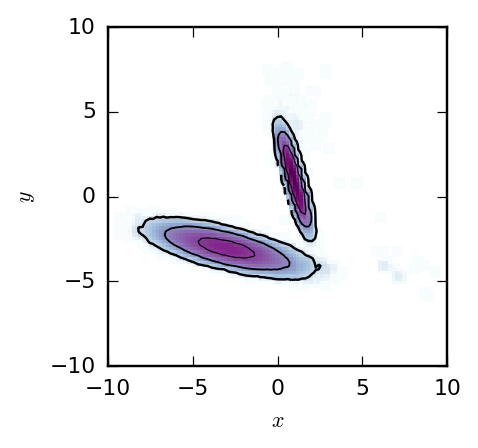

In [15]:
plot_pretty()
clevs = (0.683, 0.955, 0.997) # standard contour levels
plot_2d_dist(x, y, xlim=[-10,10], ylim = [-10,10], nxbins=100, nybins=100, clevs=clevs, smooth=True, xlabel='$x$', ylabel='$y$')

In [38]:
#Metropolis 

step=1.0
num_walkers = 64
nparams = 2
x0 = np.zeros((num_walkers,nparams))
xstart = [1,4]

for i in range(num_walkers):
    for m in range(nparams):
        x0[i,m] = rnd.normal(xstart[m],scale=step)
            

n = 20000; nburn=50; step = 1.0
x = x0
print x.shape
delta = rnd.uniform(-step,step,(2*n,num_walkers,nparams)) #random trial steps
print delta.shape
#
# a simple single chain MCMC Metropolis sampler
#
nsample = 0; i = 0  
tstart = clock()
xchain1=[]

while nsample < n:
    xtry = x + delta[i] # trial step
    #print 'x shape',x.shape
    #print 'deta shape',delta[i].shape
    gxtry = gaussian2d(xtry.T); gx = gaussian2d(x.T)
    #print gxtry.shape
    i_acc = np.where(gxtry > gx) 
    x[i_acc] = xtry[i_acc]
     
    aprob = gxtry - gx # acceptance probability
    u = rnd.uniform(0,1)
    i_acc2= np.where(u < np.exp(aprob))
    x[i_acc2] = xtry[i_acc2]
            
    xchain1.append(np.copy(x))
    
    nsample += 1
    i +=1

#print xchain
print "Metropolis for Gaussian completed in %.2f seconds"%(clock()-tstart)

(64, 2)
(40000, 64, 2)
Metropolis for Gaussian completed in 2.43 seconds


In [39]:
xchain2 = np.asarray(xchain1)

x=xchain2[:,:,0].flatten()
y=xchain2[:,:,1].flatten()

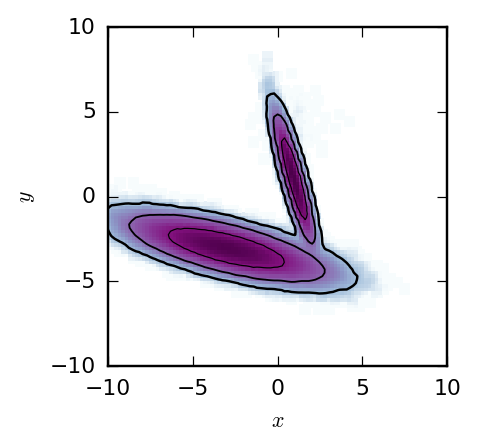

In [40]:
plot_pretty()
clevs = (0.683, 0.955, 0.997) # standard contour levels
plot_2d_dist(x, y, xlim=[-10,10], ylim = [-10,10], nxbins=100, nybins=100, clevs=clevs, smooth=True, xlabel='$x$', ylabel='$y$')

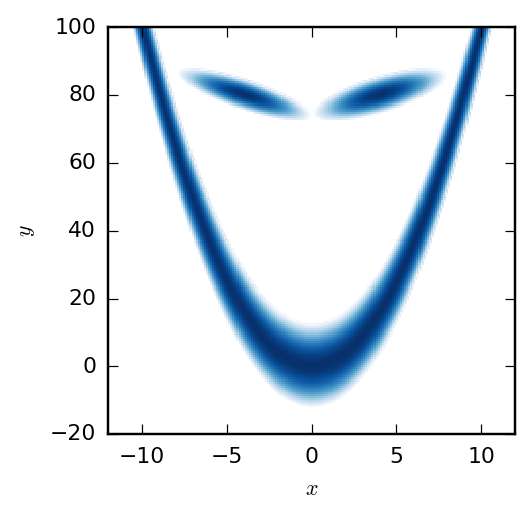

In [11]:
plot_pretty()

nxbins, nybins = 200, 200;
xlims = [-12, 12]; ylims = [-20, 100]
xbins = np.linspace(xlims[0], xlims[1], nxbins)
ybins = np.linspace(ylims[0], ylims[1], nybins)
X, Y = np.meshgrid(xbins,ybins) 

smf = smiley_face_pdf([X,Y])

fig, ax = plt.subplots(figsize=(3, 3))
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(xlims); plt.ylim(ylims)

pcol = ax.pcolormesh(X, Y, smf, cmap='Blues', norm = LogNorm(), linewidth=0., rasterized=True)


Once your implementation passes tests, run GW10 and Metropolis algorithms for a fixed number of steps and answer the following questions and report relevant results.
  
* How long does it take GW10 and Metropolis algorithms to run for a fixed number of samples? How well do the resulting samples sample the target Gaussian and "smiley face" pdfs after a fixed number of samples? 

* Think about the GW10 algorithm; can you explain why it works better for pdfs with narrow ridges or why it samples isolated peaks in the "smiley face" pdf better?  


Answers:

nsteps=20000 and num_walkers=64 <br> 
Metropolis for Gaussian completed in 2.43 seconds <br> 
GW10 for Gaussian completed in 3.47 seconds <br> 

nsteps=10000 and num_walkers=64<br> 
Metropolis for Smiley completed in 2.99 seconds<br> 
GW10 for Smiley face completed in 3.37 seconds<br> 

The time is roughly the same, but GW10 targets the narrow ridges and isolated peaks better. 

The reason for that is twofolds:
1. Ridges are sampled better because of the stretch-move that increases the probability of exploring narrow ridges because of the other ensemble of walkers.
2. Narrow peaks are sampled better because there is a higher probability of a stretch move arriving in the middle of nowhere and finding a non-zero probability e.g. a walker on one ridge stretched to move by another random walker(which is on the other ridge). The straight line between atleast some pair of walkers will cross the isolated peaks, and cause better sampling there. Metropolis has no mechanism to go beyond the neighbourhood of its initial contour, atleast not efficiently.

In [42]:
#For Smiley-face:

#Metropolis 

step=1.0
num_walkers = 64
nparams = 2
x0 = np.zeros((num_walkers,nparams))
xstart = [1,4]

for i in range(num_walkers):
    for m in range(nparams):
        x0[i,m] = rnd.normal(xstart[m],scale=step)
            

n = 20000; nburn=50; step = 1.0
x = x0
print x.shape
delta = rnd.uniform(-step,step,(2*n,num_walkers,nparams)) #random trial steps
print delta.shape
#
# a simple single chain MCMC Metropolis sampler
#
nsample = 0; i = 0  
tstart = clock()
xchain1=[]

while nsample < n:
    xtry = x + delta[i] # trial step
    #print 'x shape',x.shape
    #print 'deta shape',delta[i].shape
    gxtry = smiley_face_pdf(xtry.T); gx = smiley_face_pdf(x.T)
    #print gxtry.shape
    i_acc = np.where(gxtry > gx) 
    x[i_acc] = xtry[i_acc]
     
    aprob = gxtry - gx # acceptance probability
    u = rnd.uniform(0,1)
    i_acc2= np.where(u < np.exp(aprob))
    x[i_acc2] = xtry[i_acc2]
            
    xchain1.append(np.copy(x))
    
    nsample += 1
    i +=1

#print xchain
print "Metropolis for Smiley completed in %.2f seconds"%(clock()-tstart)

(64, 2)
(40000, 64, 2)
Metropolis for Smiley completed in 2.99 seconds


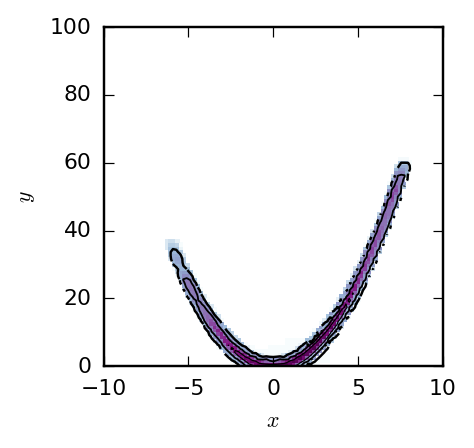

In [43]:
xchain2 = np.asarray(xchain1)

x=xchain2[:,:,0].flatten()
y=xchain2[:,:,1].flatten()

plot_pretty()
clevs = (0.683, 0.955, 0.997) # standard contour levels
plot_2d_dist(x, y, xlim=[-10,10], ylim = [0,100], nxbins=100, nybins=100, clevs=clevs, smooth=True, xlabel='$x$', ylabel='$y$')

In [54]:
#GW10 for Smiley face
#

n = 1000; 
nburn=50; 
step = [5,30]   #For both dimensions
a = 2
D = 2
num_walkers = 64
nparams = 2

x0 = np.zeros((2,num_walkers//2,nparams))
xstart = [0,50]

for i in range(2):
    for k in range(num_walkers//2):
        for m in range(nparams):
            x0[i,k,m] = rnd.normal(xstart[m],scale=step[m])


nsample = 0; i = 0; k = 0 

xfinal1 = []
nwalkers = num_walkers
n = 10000

kd=0
k=0
x=x0

tstart = clock()
for nsample in range(n):
    #print x
    for kd in [0,1]:
        k = abs(kd-1)
        
        l = rnd.randint(0,nwalkers//2,nwalkers//2)
        G = rnd.uniform(0,1,nwalkers//2)   
        zr = ((G+1)/np.sqrt(2))**2
        
        target1 = x[k][l]
        xtry = target1 + (zr*(x[kd]-target1).T).T
        
        gxtry = smiley_face_pdf(xtry.T)
        gx = smiley_face_pdf(x[kd].T)
        u = rnd.uniform(0,1)
        aprob = gxtry - gx + (D-1)*np.log10(zr)
        i_acc=np.where(aprob>np.log10(u)) 
        x[kd][i_acc]=xtry[i_acc]
        xfinal1.append(np.copy(x[kd]))

print "GW10 for Smiley face completed in %.2f seconds"%(clock()-tstart)
    

GW10 for Smiley face completed in 3.37 seconds


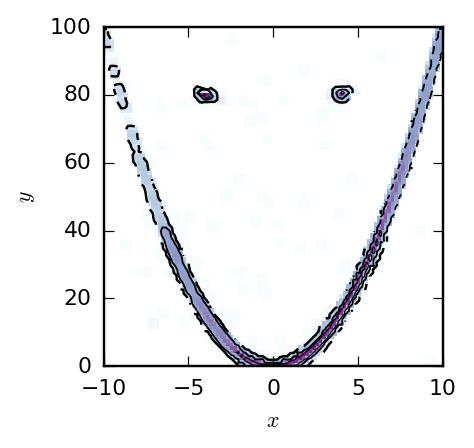

In [55]:
xfinal1 = np.asarray(xfinal1)

x=xfinal1[:,:,0].flatten()
y=xfinal1[:,:,1].flatten()

plot_pretty()
clevs = (0.683, 0.955, 0.997) # standard contour levels
plot_2d_dist(x, y, xlim=[-10,10], ylim = [0,100], nxbins=100, nybins=100, clevs=clevs, smooth=True, xlabel='$x$', ylabel='$y$')

### My Sincerest apologies for not writing a function - I had little time to debug my GW10 and hence couldn't streamline my code

### 2.  Monte Carlo forecasting of the 2016 US presidential election (25 points)

I told you about Enrico Fermi making experiment predictions using Monte Carlo sampling circa 1932 and impressing the hell out of his colleagues. Enrico Fermi also was famous for making simple but very meaningful estimates of all kinds of things (e.g., probability that an alien civilization would colonize the solar system, which led to his realization known now as the <a href="https://en.wikipedia.org/wiki/Fermi_paradox">Fermi paradox</a>). Thus, our training of ability to estimate and model things in science can be generally applicable to all kinds of phenomena around us. Hence, this last exercise is not about astrophysics, but about applying a Monte Carlo simulation method, used routinely in physics to model and forecast performance of experimental apparata, properties of physical systems (e.g., using Monte Carlo to simulate radiative transfer), etc., to forecast the outcome of 2016 Presidential election that will take place in two weeks. By completing this exercise next week you will make a prediction that will be tested a few days later. Although there are more than three candidates running, most of the other candidates are not registered in most states and polling data for them is sparse (although it is still present in the 538 table). We will thus focus on the two front-running candidates from the Democratic and Republican parties: [Hillary Clinton][4] and [Donald Trump][5], and the main third-party candidate: [Gary Johnson][6]

The Monte Carlo model we will be using is qualitatively similar to those used at election prediction sites such as [FiveThirtyEight][1] run by Nate Silver, who became famous for successfully predicting outcome of 2008 and 2012 presidential elections for each state (as an aside, Nate Silver is <a href="http://fivethirtyeight.com/sports/">currently predicting</a> 62% probability that Cubs will win the World Series; we will discuss whether there is a way to interpret this number as "prediction" after we do this homework). The reason for constructing a different model is that despite the detailed description, we don't know the specific details of Nate Silver's algorithm; we know enough to understand the logic and construct a similar model though. This also gives us the opportunity to critically think about the reasonable model assumptions and choices on our own. In this regard, if you have good suggestions for how to improve/change model calculations outlined below, you are welcome to present calculations of your own model. However, I ask you to do so only after presenting the calculation for the model outlined below for the ease of comparison of results. 

Below you will find a code snippet that reads a CSV (comma-separated value) file from the <a href="http://projects.fivethirtyeight.com/2016-election-forecast/">538 website</a> (see link at the bottom of the page) containing information about each of the 50 states as well as the District of Columbia, and you'll use this to make election predictions.
It also contains national polls, but we will ignore these as we will concentrate on predictions for each state individually and thus will use state specific polling data.  This information includes: the state name and abbreviation, the state's polls by various organizations that present percentages of people who said they will vote for one of the presidential candidates, margin of error of the poll, weights assigned to each poll, the number of people surveyed in the last poll, etc.  For each candidate, the number corresponds to the percentage of the voting population that intends to vote for them according to the polls, as well as the margin of error of the poll. 

The code also includes reading of another table that contains the number of electoral votes for each state. 

**A quick info on the US presidential election rules:** The United States does not directly elect the President and Vice President of the United States.  Instead, "Electors" are apportioned to each state based on its population according to the most recent [U.S. census][3] results (equal to the number of members of Congress to which that state receives).  Electors are typically required to vote for the candidate with the majority of the popular vote in their state.  At the moment, there are 538 Electors in the ["Electoral College"][2], and to win the presidency a candidate needs to recieve half plus one of those votes, or 270 votes.

[1]: http://fivethirtyeight.com/
[2]: https://en.wikipedia.org/wiki/Electoral_College_(United_States)
[3]: https://www.census.gov/
[4]: https://www.hillaryclinton.com/
[5]: https://www.donaldjtrump.com/
[6]: https://www.johnsonweld.com/
[7]: https://en.wikipedia.org/wiki/Normal_distribution

#### The Model and exercise instructions

The task is to build a model using Monte Carlo method to predict not just who will win the election state-by-state and nationwide, but what the range of likely outcomes will be (we call this posterior distribution in science). 

The model will use weighted average and standard deviation of the different polls existing for each state within a specified range of dates to compute the mean percentages of people that will vote for Hillary Clinton, Donald Trump, or Gary Johnson. 
The latest state-by-state poll results  <a href="http://projects.fivethirtyeight.com/general-model/president_general_polls_2016.csv">downloaded</a> from the <a href="http://projects.fivethirtyeight.com/2016-election-forecast/">538</a> website, are stored in the file <tt>data_home_dir()+'president_general_polls_2016.csv'</tt>. The code snippet below shows how to read it (using pandas library) and how to access the poll data in the table. You can see the names of the columns in the table, either by printing poll_data or by looking at the csv file directly with a spreadsheet application such as Excel. I show you how to access and extract relevant info in the function <tt>simulate_elections</tt> - which is proto-function that you will need to complete with the code implementing actual model.. 

If you look at the data I am extracting, you may notice that I extract poll results and weights for each poll, assigned by 538 to each poll, based on the <a href="http://projects.fivethirtyeight.com/pollster-ratings/">track record</a> of particular polling organization that did it. However, you may notice that I am <i>not</i> extracting poll's sampling error associated with it. This error is largely determined by the typical size of the poll ($\sim 10^3-10^4$ people, corresponding to a typical error of $\sim 1-3$%). However, we don't know how it was estimated or whether it is accurate and also we don't know whether the underlying distribution is Gaussian.  

In this situation, we can get a more reliable estimate of the polling error from the sample of state polls itself using <a href="https://en.wikipedia.org/wiki/Student%27s_t-distribution">Student's t-distribution</a>. Namely, for each state we can estimate the weighted average of $N$ poll results, and their standard deviation. Random numbers, $t$, drawn from the t-distribution with $N-1$ degrees of freedom, then will give us distribution of actual vote fractions for each candidate: $v = \bar{p} - ts$, where 
$$\bar{p}=\frac{\sum_i^{N_{\rm polls}} p_i w_i}{\sum_i^{N_{\rm polls}} w_i},$$
is the weighted average of the $N_{\rm polls}$ poll results for the state and $s$ is the standard deviation of $p_i$. The t-distribution becomes very similar to Gaussian pdf for samples of size $N_{\rm polls} >10$, but for small $N_{\rm polls}$ it has much stronger ("fatter") tails than the Gaussian. This makes outlier events considerably more likely. The most recent polls are probably the most accurate in predicting the election outcome, but as we restrict the date range the number of polls drops and this needs to be reflected in the proper modelling of vote fraction distribution (which is done by using t-distribution instead of the Gaussian with estimated sample mean and standard deviation). 

With this information in hand, carry out the following tasks: 

* <b>(a) (5 points)</b> Briefly explain the logic of using t-distribution (i.e., not what I say above, but why it describes the distribution in this case; read about it and think about why and how we apply it here.) Implement <i>your own</i> function that draws random samples from the Student t-distribution with input number of degrees of freedom. You can use any sampling method you choose, as long as you don't use any library routines except for special function routines and routines for generating uniformly distributed pseudo-random numbers. Try to use vector operations in this function as much as possible so it can generate sizeable sequences fast. Test your function against the corresponding numpy function: <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.standard_t.html">numpy.random.standard_t</a>. Plot the t-distribution for several representative numbers of degrees of freedom and compare them to the Gaussian pdf of zero mean and unit variance. If for some reason you will not be able to get your routine working, use the numpy standard_t routine for the following tasks. 

* <b>(b) (10 points).</b> Implement <i>the simplest election model:</i> 1) compute $\bar{p}$ and $s$ for each state using polls within specified range (this is already implemented in <tt>simulate_elections</tt> routine below); 2) make $N_{\rm elections}$ realizations of vote fraction for each candidate and for each state using numbers drawn from the t-distribution with the number of degrees of freedom equal to $N_{\rm polls}-1$. This will give distribution of votes among model elections for each candidate. For each model election record who is the winner and how many electoral delegates each candidate received in each model election. Almost all states are a "winner take all" state with regards to Electoral College votes, so whoever wins the popular vote receives all Electoral College votes for that state. We will ignore the fact that in a couple of states the procedure is a bit more complicated, because the number of electoral votes at stake in them is small and so this neglection will be unlikely to skew the overall result. 

Report the following results from your model: 
1) histograms showing distributions of electoral vote counts for Clinton, Trump, and Johnson among model elections. Compare your distributions to the distribution predicted by Nate Silver's model, which you can find <a href="http://projects.fivethirtyeight.com/2016-election-forecast/">at 538 website</a> (under "What to expect from the Electoral College" heading). How similar or different they are? Comment on any differences that you notice and discuss their possible origin. You may find it helpful to review the <a href="http://fivethirtyeight.com/features/a-users-guide-to-fivethirtyeights-2016-general-election-forecast/">description of how they create these forecasts</a>.

Estimate the average electoral vote count for each candidate and 95\% range around it based on the model elections. In what percentage of the model elections does Hilary Clinton win the Presidency?  How about Donald Trump and Gary Johnson?

2) How different are the results of the "popular vote" (i.e. actual vote fractions won by candidates) and Electoral College vote counts for one of the two main-party candidates.  Make scatter plots of the expected Electoral College votes vs. the fraction of popular vote received for all of the elections, and put lines indicating 50\% of the popular vote as well as the needed 270 Electoral College votes.  Is it possible to win more than half of the Electoral College vote but get less than half of the popular votes, or vice versa?  Why might this be true?

3) table (printed out or saved in a file) with a list of states with average fraction of model elections won by one of the three candidates in model elections in each state along with the 95\% range of this fraction estimated using model elections. 
Optionally, you can also represent the average outcome of elections in each state in a map drawing each state red or blue (or green for Johnson) depending on which candidate won on average. You can use a <a href="http://matplotlib.org/examples/color/colormaps_reference.html">colormap</a> such as <tt>seismic</tt> to indicate with color hues how close or landslide the election was.



In [2]:


poll_data = pandas.read_csv(data_home_dir()+'president_general_polls_2016.csv')
states_electoral = pandas.read_csv(data_home_dir()+'states_electoral.csv')

In [127]:
def t_dist(dof,n):
    
    u = rnd.normal(0,1,n)
    u = u[u>-np.sqrt(dof)]
    u = u[u<np.sqrt(dof)]
    v = rnd.uniform(0,np.exp(-0.5*(u**2)),len(u))
    w = v**(1/dof)
    
    i_acc= (w**2) + (u**2)/dof <= 1
    x = u[i_acc]/w[i_acc]
    
    return x
    

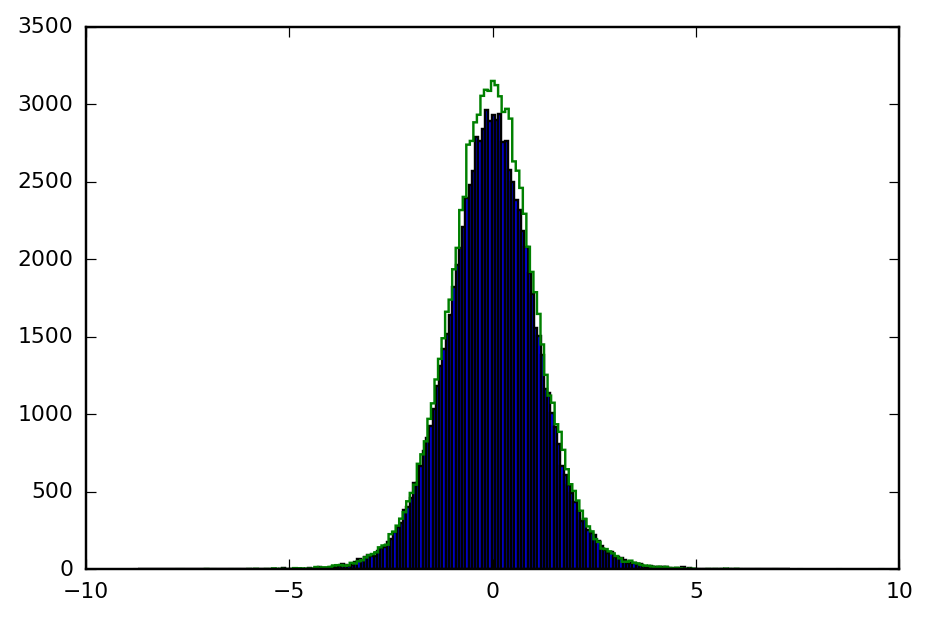

In [139]:
t = t_dist(10,100000)
l = len(t)
plt.hist(t,bins=200)
plt.hist(rnd.standard_t(10,l),bins=200,histtype='step')
plt.show()

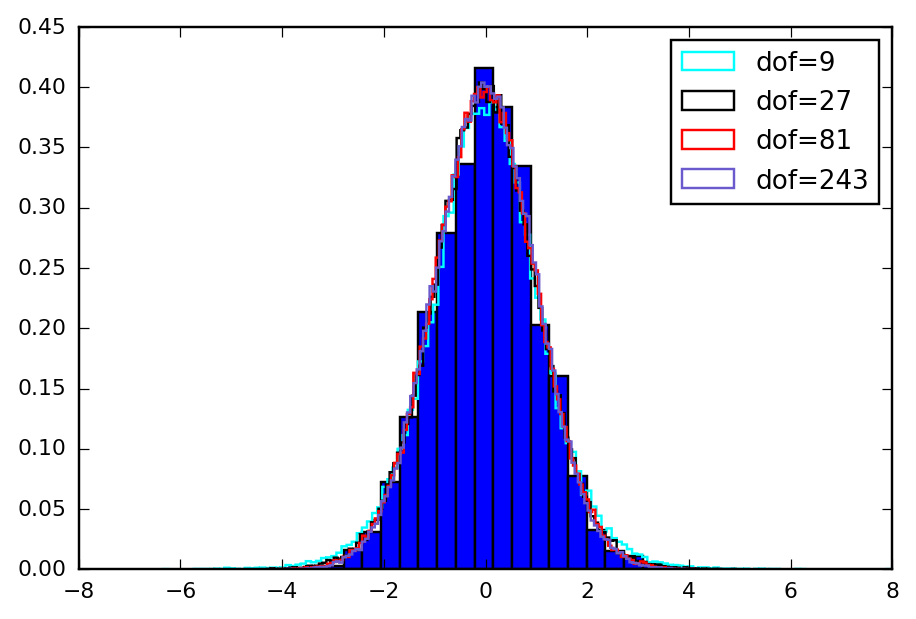

In [167]:

c = ['cyan','black','red','slateblue']

for i in range(4):
    plt.hist((t_dist(3**(i+2),100000)),bins=150,histtype='step',color=c[i],normed=True,label='dof=%.i'%3**(i+2))
    
gauss = rnd.normal(0,1,2000)
plt.hist(gauss,bins=20,zorder=0,normed=True)
plt.legend()

plt.show()

In [3]:
# example of prints showing how to access data frame data 
Nprint = 4
# print poll region (state name or nation wide, if field=U.S.) for the first Nprint entries 
print poll_data['state'][:Nprint]
# grade of the poll for the first Nprint entries 
print poll_data['enddate'][:Nprint]

print states_electoral['State'][:Nprint], states_electoral['State'].size

0       U.S.
1    Florida
2       U.S.
3       U.S.
Name: state, dtype: object
0    10/24/2016
1    10/24/2016
2    10/25/2016
3    10/25/2016
Name: enddate, dtype: object
0    AK
1    AL
2    AR
3    AZ
Name: State, dtype: object 51


In [193]:
from sklearn.covariance import shrunk_covariance, ledoit_wolf

def compute_state_covariance_matrix(states_electoral):
    """
    compute bias vectors and covariance matrix using 2008 and 2012 election results 
    """
    states      = states_electoral['State']
    state_names = states_electoral['Name']
    nstates     = states.size

    dem_results = np.zeros(nstates); rep_results = np.zeros(nstates);
    dem_polls = np.zeros((nstates,2)); rep_polls = np.zeros((nstates,2));
    for i, yr in enumerate([2008, 2012]):
        # the lines below show you how to read and extract poll and election results of 2008 and 2012 Presidential elections
        prev_election_results = pandas.read_csv(data_home_dir()+str(yr)+'-results.csv')
        dem_results += np.array(prev_election_results['Dem'])
        rep_results += np.array(prev_election_results['Rep'])
        prev_poll_results = pandas.read_csv(data_home_dir()+str(yr)+'-polls.csv')
        # average out poll results for each state
        for ist, st in enumerate(states):
            stpolls = prev_poll_results[prev_poll_results['State'] == st]
            dem_polls[ist,i] = np.mean(np.array(stpolls['Dem']))
            rep_polls[ist,i] = np.mean(np.array(stpolls['Rep']))
    
    dem_results *= 0.5; rep_results *= 0.5
    dem_polls_ave = 0.5*(dem_polls[:,0] + dem_polls[:,1])
    rep_polls_ave = 0.5*(rep_polls[:,0] + rep_polls[:,1])
    bias_dem = dem_results - dem_polls_ave
    bias_rep = rep_results - rep_polls_ave
    dem_polls[:,0] -= dem_polls_ave; dem_polls[:,1] -= dem_polls_ave
    rep_polls[:,0] -= rep_polls_ave; rep_polls[:,1] -= rep_polls_ave
    cov_dem = np.cov(dem_polls); cov_rep = np.cov(rep_polls)
    
    #cov_dem_my = np.zeros_like(cov_dem)
    #for i in range(nstates):
    #    for j in range(nstates):
    #        cov_dem_my[i,j] = (dem_polls[i,0]*dem_polls[j,0] + dem_polls[i,1]*dem_polls[j,1])
    # regularize empirical covariance matrix estimate
    #shrinkage = 1.e-14 # small shrinkage parameter to make cov matrix positive semi-definite
    #cov_dem = shrunk_covariance(cov_dem, shrinkage = shrinkage)
    #cov_rep = shrunk_covariance(cov_dem, shrinkage = shrinkage)
    cov_dem, shr_dem = ledoit_wolf(cov_dem)
    cov_rep, shr_rep = ledoit_wolf(cov_rep)
    #print "shrinkages:", shr_dem, shr_rep
    # make sure that matrices are positive definite
    if not np.all(np.linalg.eigvals(cov_dem) > 0):
        raise Exception("cov_dem is not positive definite, try increasing shrinkage parameter")
    if not np.all(np.linalg.eigvals(cov_rep) > 0):
        raise Exception("cov_rep is not positive definite, try increasing shrinkage parameter")
        
    return bias_dem, cov_dem, bias_rep, cov_rep

In [194]:
bias_dem, cov_dem, bias_rep, cov_rep = compute_state_covariance_matrix(states_electoral)

Ldem = np.linalg.cholesky(cov_dem)
Lrep = np.linalg.cholesky(cov_rep)


In [6]:
#Part (a)

#Student's t-distribution

#G = rnd.uniform(0,1,len())   
#t = ((G+1)/np.sqrt(2))**2   #Draw random t's from student-t dist.


nsims = 10
dof = nsims - 1 

rnd.standard_t(nsims-1,nsims)

array([ 0.85672196,  1.31641659, -0.29354304,  0.33361226, -0.22127565,
       -0.41711565, -0.3516247 ,  0.44656606, -0.66198446, -1.38866159])

In [181]:
def simulate_elections(poll_data, states_electoral, date_range, poll_type, nsims = 4,dem_bias=np.zeros(51),rep_bias=np.zeros(51)):
    """
    routine to simulate outcome of 2016 presidential election that you need to complete
    poll_data = data frame containing polling data from 538 website
    states_electoral = data frame containing the number of electoral votes and population of each state
    date_range = specify range of dates from which to use the polls: e.g., date_range=['10-01-2016', '10-30-2016']
                 to use all polls do date_range=['01-01-2016', '10-30-2016']
    """
    states      = states_electoral['State']
    state_names = states_electoral['Name']
    electors    = states_electoral['Electors']
    nstates     = states.size

    # get the dates of the polls from the 538 poll data
    dates = pandas.to_datetime(poll_data['startdate'])

    # prepare arrays
    ave_clinton, std_clinton, n_clinton = np.zeros(nstates), np.zeros(nstates), np.zeros(nstates, dtype=np.int); 
    ave_trump,   std_trump,   n_trump   = np.zeros(nstates), np.zeros(nstates), np.zeros(nstates, dtype=np.int); 
    ave_johnson, std_johnson, n_johnson = np.zeros(nstates), np.zeros(nstates), np.zeros(nstates, dtype=np.int);
    
    clinton_vote_dist = np.zeros((nstates,nsims))
    trump_vote_dist   = np.zeros((nstates,nsims))
    johnson_vote_dist = np.zeros((nstates,nsims))
    clinton_electoral_votes = np.zeros(nsims)
    trump_electoral_votes   = np.zeros(nsims)
    johnson_electoral_votes = np.zeros(nsims)
    
    
    ndraws = 0 
    clinton_vote=0
    johnson_vote=0
    trump_vote=0
    
    electoral_votes = np.zeros((3,nstates,nsims))
    total_votes = np.zeros((3,nstates,nsims))
    
    v_clinton = np.zeros(nsims)
    v_trump = np.zeros(nsims)
    v_johnson = np.zeros(nsims)
    
    
    for i, state in enumerate(state_names):
        # select polls data for this state within specified range of dates
        poll_state = poll_data[(poll_data['state'] == state) & (dates > date_range[0]) & (dates < date_range[1])]
        # extract weights assigned to each poll, based on its nature and grade of the polling organization
        poll_weights = poll_state['poll_wt']
        # extract poll results for Trump, Clinton, and Johnson
        trump_polls   = poll_state[poll_type+'_trump']
        clinton_polls = poll_state[poll_type+'_clinton']
        johnson_polls = poll_state[poll_type+'_johnson']
        johnson_polls = johnson_polls.fillna(0)
        clinton_polls = clinton_polls.fillna(0)
        trump_polls = trump_polls.fillna(0)
        # computed weighted average of the polls, and standard deviation, as well as the number of polls for this state
        ave_clinton[i], std_clinton[i],  n_clinton[i] = np.average(clinton_polls, weights=poll_weights), np.std(clinton_polls, ddof=1), clinton_polls.size 
        ave_trump[i],   std_trump[i],    n_trump[i]   = np.average(trump_polls, weights=poll_weights),   np.std(trump_polls, ddof=1),   trump_polls.size 
        ave_johnson[i], std_johnson[i],  n_johnson[i] = np.average(johnson_polls, weights=poll_weights), np.std(johnson_polls, ddof=1), johnson_polls.size 

        
        t1 = rnd.standard_t(n_clinton[i]-1,nsims)   #A 1D array of t values for every realization of the general election (length of array = number of states)
        v_clinton = ave_clinton[i] - t1*std_clinton[i] - dem_bias[i]      #This is being calculated for every nsim 
        t2 = rnd.standard_t(n_trump[i]-1,nsims)
        v_trump = ave_trump[i] - t2*std_trump[i] - rep_bias[i]
        t3 = rnd.standard_t(n_johnson[i]-1,nsims)
        v_johnson = ave_johnson[i] - t3*std_johnson[i]

        #print v_clinton.shape
        #print v_johnson.shape
        #print v_trump.shape


        maximum = np.argmax([v_clinton,v_trump,v_johnson],axis=0)
        ns = np.arange(nsims)
        
        electoral_votes[maximum,i,ns] += electors[i]
        total_votes[:,i,ns] += np.array([v_clinton,v_trump,v_johnson])
        
        
        #print total_votes.shape
        #print np.array([v_clinton,v_trump,v_johnson]).shape
        #print electors[i]
        #print electoral_votes[maximum,i,:]
        #print electoral_votes
        #print maximum.shape


    clinton_electoral = electoral_votes[0,:,:]
    trump_electoral = electoral_votes[1,:,:]
    johnson_electoral = electoral_votes[2,:,:]
    
        
    # complete this function to compute simulated distribution of electoral votes for each state using nsims=20000 (or more) simulations
    #dummy1, dummy2, dummy3 = 0, 0, 0; ndraws = 0 
    #print 'clinton_vote', clinton_vote
    
    #print 'clinton_vote_dist', clinton_vote_dist
       
    return clinton_electoral,trump_electoral,johnson_electoral,total_votes

In [182]:
poll_type = 'rawpoll'
date_range = ['10-15-2016', '10-30-2016']
nsims = 1000
clinton_electoral_votes, trump_electoral_votes, johnson_electoral_votes, total_votes = simulate_elections(poll_data, states_electoral, 
                                                                                             date_range, poll_type, nsims = nsims)


In [183]:
#print clinton_electoral_votes

Clinton
------
Average electoral votes= 329.392
5th percentile= 288.0
95th percentile= 371.0
Probability of winning = 0.992
Trump
------
Average electoral votes= 208.608
5th percentile= 167.0
95th percentile= 250.0
Probability of winning = 0.005
Johnson
------
Average electoral votes= 0
5th percentile= 0
95th percentile= 0
Probability of winning = 0.0


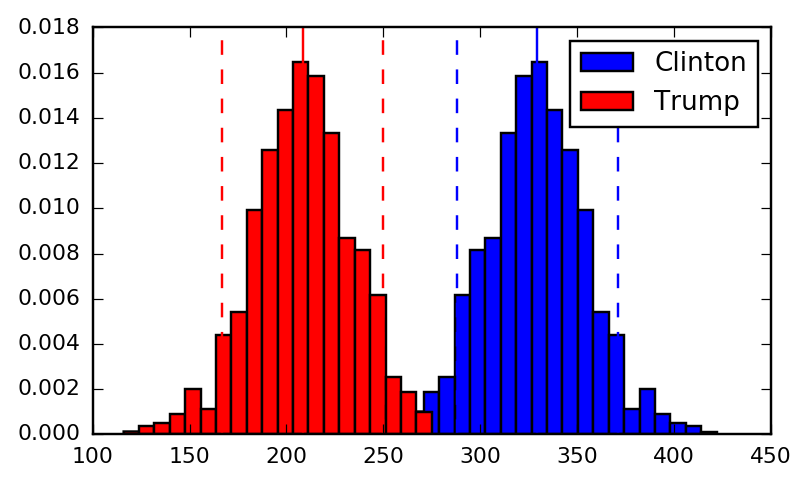

In [185]:
clinton_elec = np.sum(clinton_electoral_votes,axis=0)
trump_elec = np.sum(trump_electoral_votes,axis=0)
johnson_elec = np.sum(johnson_electoral_votes,axis=0)

clinton_act = np.sum(total_votes[0,:,:],axis=0)
trump_act = np.sum(total_votes[1,:,:],axis=0)
johnson_act = np.sum(total_votes[2,:,:],axis=0)
total = clinton_act+trump_act+johnson_act

clinton_ave = np.mean(clinton_elec)
c5 = np.percentile(clinton_elec,5)
c95 = np.percentile(clinton_elec,95)

trump_ave = np.mean(trump_elec)
t5 = np.percentile(trump_elec,5)
t95 = np.percentile(trump_elec,95)

clinton_win = len(clinton_elec[clinton_elec>270])
trump_win = len(trump_elec[trump_elec>270])
johnson_win = len(johnson_elec[johnson_elec>270])


print 'Clinton'
print '------'
print 'Average electoral votes=', clinton_ave
print '5th percentile=', c5
print '95th percentile=', c95
print 'Probability of winning =',clinton_win/nsims

print 'Trump'
print '------'
print 'Average electoral votes=', trump_ave
print '5th percentile=', t5
print '95th percentile=', t95
print 'Probability of winning =',trump_win/nsims

print 'Johnson'
print '------'
print 'Average electoral votes=', 0
print '5th percentile=', 0
print '95th percentile=', 0
print 'Probability of winning =',0/nsims


plot_pretty()
plt.figure(figsize=(5,3))


plt.hist(clinton_elec,bins=20,label='Clinton',normed=True)
plt.axvline(c5,color='blue',ls='--')
plt.axvline(c95,color='blue',ls='--')
plt.axvline(clinton_ave,color='blue')

plt.hist(trump_elec,bins=20,color='red',label='Trump',normed=True)
plt.axvline(t5,color='red',ls='--')
plt.axvline(t95,color='red',ls='--')
plt.axvline(trump_ave,color='red')

plt.legend(loc='upper right')

plt.show()




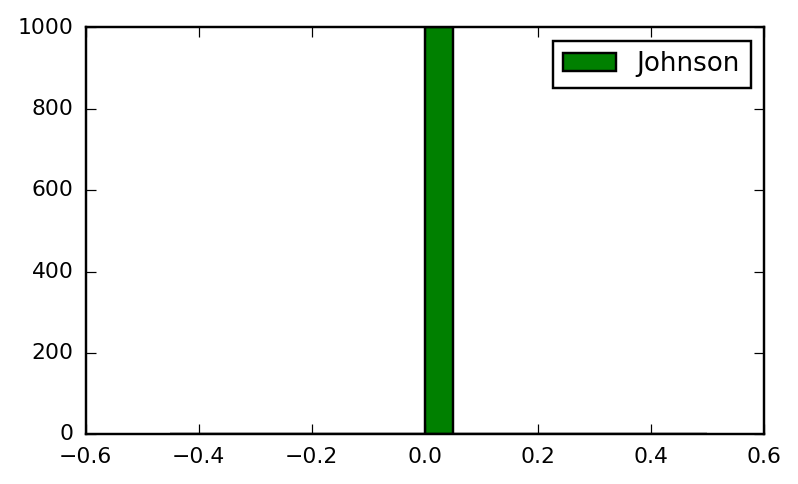

In [186]:
plot_pretty()
plt.figure(figsize=(5,3))

plt.hist(johnson_elec,bins=20,color='green',label='Johnson')

plt.legend(loc='upper right')

plt.show()


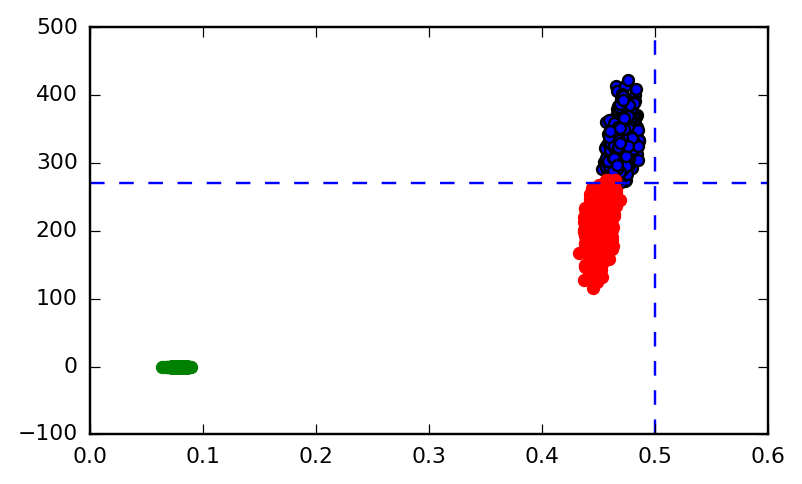

In [187]:
plot_pretty()
plt.figure(figsize=(5,3))

plt.scatter(clinton_act/total,clinton_elec)
plt.scatter(trump_act/total,trump_elec,color='red')
plt.scatter(johnson_act/total,johnson_elec,color='green')
plt.axvline(0.5,ls='--')
plt.axhline(270,ls='--')

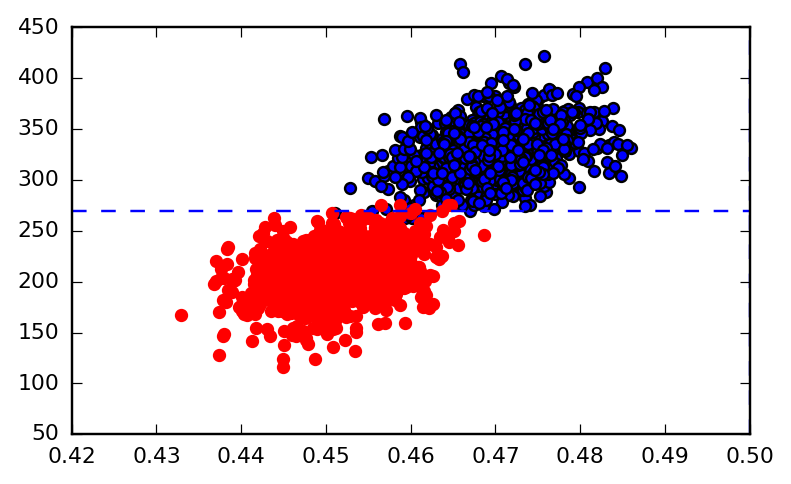

In [188]:
plot_pretty()
plt.figure(figsize=(5,3))

plt.scatter(clinton_act/total,clinton_elec)
plt.scatter(trump_act/total,trump_elec,color='red')
#plt.scatter(johnson_act/total,johnson_elec,color='green')
plt.axvline(0.5,ls='--')
plt.axhline(270,ls='--')

In [125]:
#Table:
state_names = states_electoral['Name']
for i,state in enumerate(state_names):
    
    clinton = total_votes[0,i,:] ; l = len(clinton)
    trump = total_votes[1,i,:]
    johnson = total_votes[2,i,:]
    total = clinton + trump + johnson
    
    
    
    maxvotes = np.argmax(total_votes[:,i,:],axis=0)
    
    c = len(maxvotes[maxvotes ==0])
    t = len(maxvotes[maxvotes ==1])
    g = len(maxvotes[maxvotes ==2])
    
    
    print 'State:',state
    print '----------'
    
    print 'Percentage of elections by Hillary',100* c/l
    print 'Percentage of elections by Trump', 100*t/l
    print 'Percentage of elections by Johnson', 100*g/l
    
    
    
    

State: Alaska
----------
Percentage of elections by Hillary 7.8
Percentage of elections by Trump 92.2
Percentage of elections by Johnson 0.0
State: Alabama
----------
Percentage of elections by Hillary 0.8
Percentage of elections by Trump 99.2
Percentage of elections by Johnson 0.0
State: Arkansas
----------
Percentage of elections by Hillary 1.6
Percentage of elections by Trump 98.4
Percentage of elections by Johnson 0.0
State: Arizona
----------
Percentage of elections by Hillary 47.6
Percentage of elections by Trump 52.4
Percentage of elections by Johnson 0.0
State: California
----------
Percentage of elections by Hillary 100.0
Percentage of elections by Trump 0.0
Percentage of elections by Johnson 0.0
State: Colorado
----------
Percentage of elections by Hillary 78.6
Percentage of elections by Trump 21.4
Percentage of elections by Johnson 0.0
State: Connecticut
----------
Percentage of elections by Hillary 99.5
Percentage of elections by Trump 0.5
Percentage of elections by Johnson


* <b>c. (10 points).</b> <i>A more realistic model?</i> The simple model described above assumes that poll results for each state are independent and are unbiased. Even a cursory knowledge of what's involved in these polls indicates that this is likely a very flawed assumption (see, e.g., <a href="http://www.nytimes.com/2016/10/13/upshot/the-savvy-persons-guide-to-reading-the-latest-polls.html">this New York Times story</a> from a year ago). The polls were shown to be biased in many states in the 2012 Presidential election and also during recent "Brexit" vote in the UK. The perceptions and voting patterns of populations in states that are similar culturally and demographically are probably also correlated. To a large extent these correlations should already be reflected in the poll results, but subtle biases creep in, like the fact that polls reach people in the inner cities less than populations in the rural areas. Once you think about the possible sources of bias and covariance, things quickly start to look complicated. However, we can stay with the spirit of the empirical basis of the model to estimate the biases and correlations using results of previous 2008 and 2012 presidential elections. 

I've included files <tt>2008-polls.csv, 2008-results.csv, 2012-polls.csv, 2012-results.csv</tt> which provide information about what polls predicted for each state in the last two elections and what the actual results were. The data is only for the two main candidates from Republican (McCain and Romney) and Democratic parties (Obama in both elections). To estimate the bias we can subtract results from poll predictions for both republicans and democrats, and average results for the two parties separately among two elections. This average gives us the poll bias estimate for each party and each state. We can also compute the <a href="http://www.itl.nist.gov/div898/handbook/pmc/section5/pmc541.htm">correlation matrix</a> for this average, which encodes correlations of the biases and poll errors among states. The data for this calculation is prepared in the routine <tt>compute_state_correlation_matrix</tt> below. 

With the bias vectors and correlation matrices, we can construct a more sophisticated model, in which the random realizations of vote fractions for Clinton and Trump for each state will be turned into biased and correlated random realizations. The bias is produced by simply adding the bias value for each state and estimated for each of the two party to each random realization of vote fraction for the candidate of that party. Correlations in the bias among states will be enforced by turning random numbers into correlated random numbers. 

This can be done using the <a href="http://www.numericalexpert.com/blog/correlated_random_variables/">method based on the Cholesky matrix decomposition,</a> (see also <a href="https://www.sitmo.com/?p=720">here</a>) which is outlined in the S 2.3 of the notes. I will not be covering matrix algebra algorithms in this course, due to lack of time and also because I think there is limited amount of useful information that can be learned from the algorithms themselves (there are various useful thing to know about <i>usage</i> of matrix algebra and associated numerical issues, however). So, here you can use the numpy routine performing Cholesky decomposition: <a href="https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linalg.cholesky.html"><tt>numpy.linalg.cholesky</tt></a>.

Implement the model with induced bias and correlation on the random numbers drawn from t-distribution. Repeat the same predictions listed in the part b above. What difference do you see? Interpret any difference or lack thereof. 


In [190]:
poll_type = 'rawpoll'
date_range = ['10-15-2016', '10-30-2016']
nsims = 1000
clinton_electoral_votes, trump_electoral_votes, johnson_electoral_votes, total_votes = simulate_elections(poll_data, states_electoral, 
                                                                                             date_range, poll_type, nsims = nsims,dem_bias=bias_dem,rep_bias=bias_rep)

Clinton
------
Average electoral votes= 307.616
5th percentile= 260.0
95th percentile= 360.0
Probability of winning = 0.895
Trump
------
Average electoral votes= 230.381
5th percentile= 178.0
95th percentile= 278.0
Probability of winning = 0.092
Johnson
------
Average electoral votes= 0
5th percentile= 0
95th percentile= 0
Probability of winning = 0.0


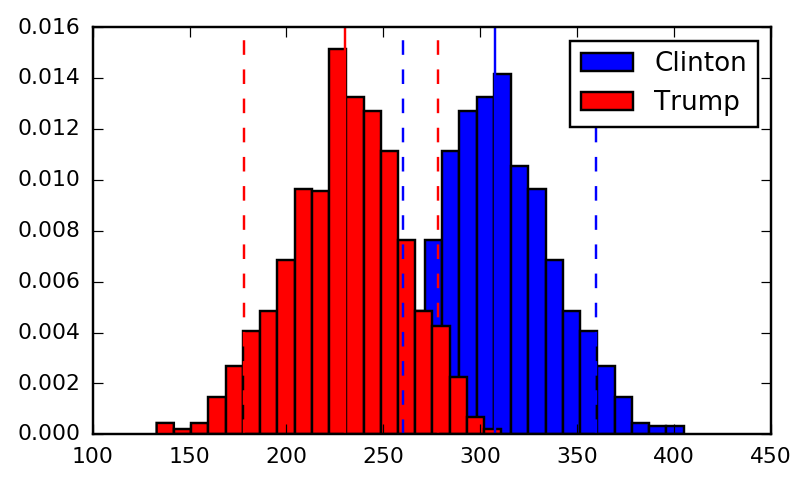

In [191]:
clinton_elec = np.sum(clinton_electoral_votes,axis=0)
trump_elec = np.sum(trump_electoral_votes,axis=0)
johnson_elec = np.sum(johnson_electoral_votes,axis=0)

clinton_act = np.sum(total_votes[0,:,:],axis=0)
trump_act = np.sum(total_votes[1,:,:],axis=0)
johnson_act = np.sum(total_votes[2,:,:],axis=0)
total = clinton_act+trump_act+johnson_act

clinton_ave = np.mean(clinton_elec)
c5 = np.percentile(clinton_elec,5)
c95 = np.percentile(clinton_elec,95)

trump_ave = np.mean(trump_elec)
t5 = np.percentile(trump_elec,5)
t95 = np.percentile(trump_elec,95)



clinton_win = len(clinton_elec[clinton_elec>270])
trump_win = len(trump_elec[trump_elec>270])
johnson_win = len(johnson_elec[johnson_elec>270])


print 'Clinton'
print '------'
print 'Average electoral votes=', clinton_ave
print '5th percentile=', c5
print '95th percentile=', c95
print 'Probability of winning =',clinton_win/nsims

print 'Trump'
print '------'
print 'Average electoral votes=', trump_ave
print '5th percentile=', t5
print '95th percentile=', t95
print 'Probability of winning =',trump_win/nsims

print 'Johnson'
print '------'
print 'Average electoral votes=', 0
print '5th percentile=', 0
print '95th percentile=', 0
print 'Probability of winning =',0/nsims


plot_pretty()
plt.figure(figsize=(5,3))


plt.hist(clinton_elec,bins=20,label='Clinton',normed=True)
plt.axvline(c5,color='blue',ls='--')
plt.axvline(c95,color='blue',ls='--')
plt.axvline(clinton_ave,color='blue')

plt.hist(trump_elec,bins=20,color='red',label='Trump',normed=True)
plt.axvline(t5,color='red',ls='--')
plt.axvline(t95,color='red',ls='--')
plt.axvline(trump_ave,color='red')

plt.legend(loc='upper right')

plt.show()



In [206]:
#Cholesky decomposition

def simulate_elections_cho(poll_data, states_electoral, date_range, poll_type, nsims = 4,dem_bias=np.zeros(51),rep_bias=np.zeros(51),L_dem=None,L_rep=None):
    """
    routine to simulate outcome of 2016 presidential election that you need to complete
    poll_data = data frame containing polling data from 538 website
    states_electoral = data frame containing the number of electoral votes and population of each state
    date_range = specify range of dates from which to use the polls: e.g., date_range=['10-01-2016', '10-30-2016']
                 to use all polls do date_range=['01-01-2016', '10-30-2016']
    """
    states      = states_electoral['State']
    state_names = states_electoral['Name']
    electors    = states_electoral['Electors']
    nstates     = states.size

    # get the dates of the polls from the 538 poll data
    dates = pandas.to_datetime(poll_data['startdate'])

    # prepare arrays
    ave_clinton, std_clinton, n_clinton = np.zeros(nstates), np.zeros(nstates), np.zeros(nstates, dtype=np.int); 
    ave_trump,   std_trump,   n_trump   = np.zeros(nstates), np.zeros(nstates), np.zeros(nstates, dtype=np.int); 
    ave_johnson, std_johnson, n_johnson = np.zeros(nstates), np.zeros(nstates), np.zeros(nstates, dtype=np.int);
    
    clinton_vote_dist = np.zeros((nstates,nsims))
    trump_vote_dist   = np.zeros((nstates,nsims))
    johnson_vote_dist = np.zeros((nstates,nsims))
    clinton_electoral_votes = np.zeros(nsims)
    trump_electoral_votes   = np.zeros(nsims)
    johnson_electoral_votes = np.zeros(nsims)
    
    
    ndraws = 0 
    clinton_vote=0
    johnson_vote=0
    trump_vote=0
    
    electoral_votes = np.zeros((3,nstates,nsims))
    total_votes = np.zeros((3,nstates,nsims))
    
    v_clinton = np.zeros(nsims)
    v_trump = np.zeros(nsims)
    v_johnson = np.zeros(nsims)
    
    
    tc= []
    tt=[]
    tj=[]
    for i, state in enumerate(state_names):
        # select polls data for this state within specified range of dates
        poll_state = poll_data[(poll_data['state'] == state) & (dates > date_range[0]) & (dates < date_range[1])]
        # extract weights assigned to each poll, based on its nature and grade of the polling organization
        poll_weights = poll_state['poll_wt']
        # extract poll results for Trump, Clinton, and Johnson
        trump_polls   = poll_state[poll_type+'_trump']
        clinton_polls = poll_state[poll_type+'_clinton']
        johnson_polls = poll_state[poll_type+'_johnson']
        johnson_polls = johnson_polls.fillna(0)
        clinton_polls = clinton_polls.fillna(0)
        trump_polls = trump_polls.fillna(0)
        # computed weighted average of the polls, and standard deviation, as well as the number of polls for this state
        ave_clinton[i], std_clinton[i],  n_clinton[i] = np.average(clinton_polls, weights=poll_weights), np.std(clinton_polls, ddof=1), clinton_polls.size 
        ave_trump[i],   std_trump[i],    n_trump[i]   = np.average(trump_polls, weights=poll_weights),   np.std(trump_polls, ddof=1),   trump_polls.size 
        ave_johnson[i], std_johnson[i],  n_johnson[i] = np.average(johnson_polls, weights=poll_weights), np.std(johnson_polls, ddof=1), johnson_polls.size 

        tc.append(rnd.standard_t(n_clinton[i]-1,nsims))   #A 1D array of t values for every realization of the general election (length of array = number of states)         
        tt.append(rnd.standard_t(n_trump[i]-1,nsims))
        tj.append(rnd.standard_t(n_johnson[i]-1,nsims))

    tc=np.asarray(tc)
    tt=np.asarray(tt)
    tj=np.asarray(tj)
    
    ltc = np.dot(L_dem,tc).T
    ltt = np.dot(L_rep,tt).T
    ltj = tj.T
    
    for i, state in enumerate(state_names):
        # select polls data for this state within specified range of dates
        poll_state = poll_data[(poll_data['state'] == state) & (dates > date_range[0]) & (dates < date_range[1])]
        # extract weights assigned to each poll, based on its nature and grade of the polling organization
        poll_weights = poll_state['poll_wt']
        # extract poll results for Trump, Clinton, and Johnson
        trump_polls   = poll_state[poll_type+'_trump']
        clinton_polls = poll_state[poll_type+'_clinton']
        johnson_polls = poll_state[poll_type+'_johnson']
        johnson_polls = johnson_polls.fillna(0)
        clinton_polls = clinton_polls.fillna(0)
        trump_polls = trump_polls.fillna(0)
        # computed weighted average of the polls, and standard deviation, as well as the number of polls for this state
        ave_clinton[i], std_clinton[i],  n_clinton[i] = np.average(clinton_polls, weights=poll_weights), np.std(clinton_polls, ddof=1), clinton_polls.size 
        ave_trump[i],   std_trump[i],    n_trump[i]   = np.average(trump_polls, weights=poll_weights),   np.std(trump_polls, ddof=1),   trump_polls.size 
        ave_johnson[i], std_johnson[i],  n_johnson[i] = np.average(johnson_polls, weights=poll_weights), np.std(johnson_polls, ddof=1), johnson_polls.size 

        
        print ltc[:,i].shape
        
        #t1 = rnd.standard_t(n_clinton[i]-1,nsims)   #A 1D array of t values for every realization of the general election (length of array = number of states)
        v_clinton = ave_clinton[i] - ltc[:,i]*std_clinton[i] - dem_bias[i]      #This is being calculated for every nsim 
        #t2 = rnd.standard_t(n_trump[i]-1,nsims)
        v_trump = ave_trump[i] - ltt[:,i]*std_trump[i] - rep_bias[i]
        #t3 = rnd.standard_t(n_johnson[i]-1,nsims)
        v_johnson = ave_johnson[i] - ltj[:,i]*std_johnson[i]

        print v_clinton.shape
        print v_johnson.shape
        print v_trump.shape

        

        maximum = np.argmax([v_clinton,v_trump,v_johnson],axis=0)
        ns = np.arange(nsims)
        
        electoral_votes[maximum,i,ns] += electors[i]
        total_votes[:,i,ns] += np.array([v_clinton,v_trump,v_johnson])
        
        
        #print total_votes.shape
        #print np.array([v_clinton,v_trump,v_johnson]).shape
        #print electors[i]
        #print electoral_votes[maximum,i,:]
        #print electoral_votes
        #print maximum.shape


    clinton_electoral = electoral_votes[0,:,:]
    trump_electoral = electoral_votes[1,:,:]
    johnson_electoral = electoral_votes[2,:,:]
    
        
    # complete this function to compute simulated distribution of electoral votes for each state using nsims=20000 (or more) simulations
    #dummy1, dummy2, dummy3 = 0, 0, 0; ndraws = 0 
    #print 'clinton_vote', clinton_vote
    
    #print 'clinton_vote_dist', clinton_vote_dist
       
    return clinton_electoral,trump_electoral,johnson_electoral,total_votes

In [207]:
poll_type = 'rawpoll'
date_range = ['10-15-2016', '10-30-2016']
nsims = 1000
clinton_electoral_votes, trump_electoral_votes, johnson_electoral_votes, total_votes = simulate_elections_cho(poll_data, states_electoral, 
                                                                                             date_range, poll_type, nsims = nsims,dem_bias=bias_dem,rep_bias=bias_rep,L_dem=Ldem,L_rep=Lrep)

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


Clinton
------
Average electoral votes= 308.405
5th percentile= 235.95
95th percentile= 369.0
Probability of winning = 0.796
Trump
------
Average electoral votes= 227.791
5th percentile= 165.0
95th percentile= 298.0
Probability of winning = 0.179
Johnson
------
Average electoral votes= 0
5th percentile= 0
95th percentile= 0
Probability of winning = 0.0


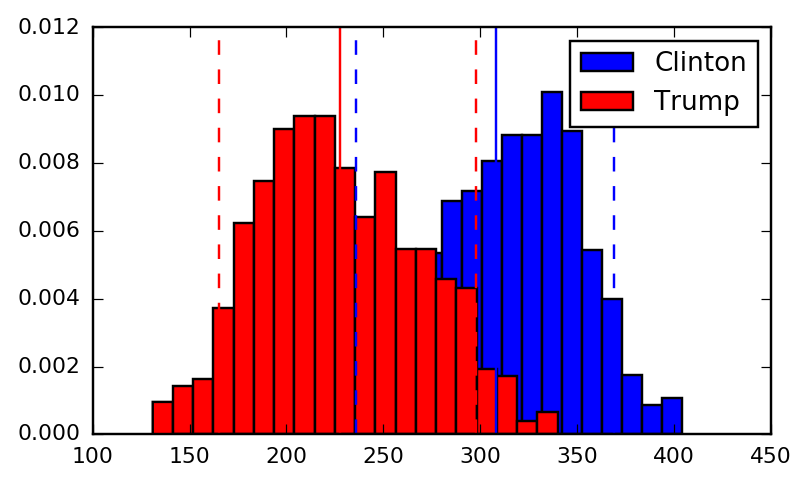

In [208]:
clinton_elec = np.sum(clinton_electoral_votes,axis=0)
trump_elec = np.sum(trump_electoral_votes,axis=0)
johnson_elec = np.sum(johnson_electoral_votes,axis=0)

clinton_act = np.sum(total_votes[0,:,:],axis=0)
trump_act = np.sum(total_votes[1,:,:],axis=0)
johnson_act = np.sum(total_votes[2,:,:],axis=0)
total = clinton_act+trump_act+johnson_act

clinton_ave = np.mean(clinton_elec)
c5 = np.percentile(clinton_elec,5)
c95 = np.percentile(clinton_elec,95)

trump_ave = np.mean(trump_elec)
t5 = np.percentile(trump_elec,5)
t95 = np.percentile(trump_elec,95)



clinton_win = len(clinton_elec[clinton_elec>270])
trump_win = len(trump_elec[trump_elec>270])
johnson_win = len(johnson_elec[johnson_elec>270])


print 'Clinton'
print '------'
print 'Average electoral votes=', clinton_ave
print '5th percentile=', c5
print '95th percentile=', c95
print 'Probability of winning =',clinton_win/nsims

print 'Trump'
print '------'
print 'Average electoral votes=', trump_ave
print '5th percentile=', t5
print '95th percentile=', t95
print 'Probability of winning =',trump_win/nsims

print 'Johnson'
print '------'
print 'Average electoral votes=', 0
print '5th percentile=', 0
print '95th percentile=', 0
print 'Probability of winning =',0/nsims


plot_pretty()
plt.figure(figsize=(5,3))


plt.hist(clinton_elec,bins=20,label='Clinton',normed=True)
plt.axvline(c5,color='blue',ls='--')
plt.axvline(c95,color='blue',ls='--')
plt.axvline(clinton_ave,color='blue')

plt.hist(trump_elec,bins=20,color='red',label='Trump',normed=True)
plt.axvline(t5,color='red',ls='--')
plt.axvline(t95,color='red',ls='--')
plt.axvline(trump_ave,color='red')

plt.legend(loc='upper right')

plt.show()



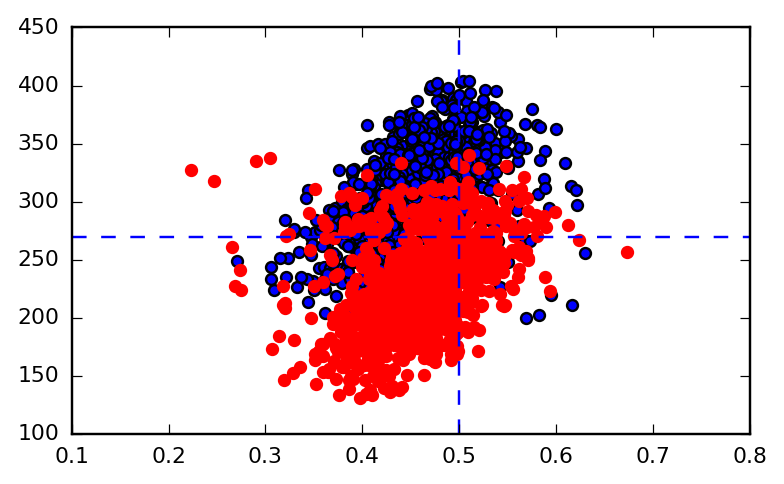

In [209]:
plot_pretty()
plt.figure(figsize=(5,3))

plt.scatter(clinton_act/total,clinton_elec)
plt.scatter(trump_act/total,trump_elec,color='red')
#plt.scatter(johnson_act/total,johnson_elec,color='green')
plt.axvline(0.5,ls='--')
plt.axhline(270,ls='--')

In [210]:
#Table:
state_names = states_electoral['Name']
for i,state in enumerate(state_names):
    
    clinton = total_votes[0,i,:] ; l = len(clinton)
    trump = total_votes[1,i,:]
    johnson = total_votes[2,i,:]
    total = clinton + trump + johnson
    
    
    
    maxvotes = np.argmax(total_votes[:,i,:],axis=0)
    
    c = len(maxvotes[maxvotes ==0])
    t = len(maxvotes[maxvotes ==1])
    g = len(maxvotes[maxvotes ==2])
    
    
    print 'State:',state
    print '----------'
    
    print 'Percentage of elections by Hillary',100* c/l
    print 'Percentage of elections by Trump', 100*t/l
    print 'Percentage of elections by Johnson', 100*g/l
    
    
    

State: Alaska
----------
Percentage of elections by Hillary 39.4
Percentage of elections by Trump 56.9
Percentage of elections by Johnson 3.7
State: Alabama
----------
Percentage of elections by Hillary 24.8
Percentage of elections by Trump 74.7
Percentage of elections by Johnson 0.5
State: Arkansas
----------
Percentage of elections by Hillary 40.0
Percentage of elections by Trump 59.5
Percentage of elections by Johnson 0.5
State: Arizona
----------
Percentage of elections by Hillary 55.6
Percentage of elections by Trump 44.4
Percentage of elections by Johnson 0.0
State: California
----------
Percentage of elections by Hillary 87.7
Percentage of elections by Trump 12.3
Percentage of elections by Johnson 0.0
State: Colorado
----------
Percentage of elections by Hillary 50.6
Percentage of elections by Trump 49.4
Percentage of elections by Johnson 0.0
State: Connecticut
----------
Percentage of elections by Hillary 65.9
Percentage of elections by Trump 34.1
Percentage of elections by Joh

# Comments:

1. Correlation biases changes things. Polls in states that have correlations in race,education, background, religion generally respond to similar political ideologies, and hence vote roughly the same. This is crucial and a more realistic model of what to expect on Tuesday.

2. Bias in statistical polls is towards democrats. It can be shown that democrats generally respond to stat polls, which might not be a stochastic representation of what is actually goin on at the grassroot level e.g. a democrat is shown to be more accessible to a phone/internet poll that news channels or statisticians adhere to.



You can use the example code below to create a map of the predicted wins for Clinton and Trump state by state (democrats are traditionally colored blue, republicans as red). You will need to install <a href="https://github.com/matplotlib/basemap">mpl_toolkits.basemap</a>, if you don't have it for this. This map is not required - the minimum required is print out of a table with predictions for each state specified above. The map is just a good way to summarize the predictions pictorially. 

In [ ]:


# create the map
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
map.readshapefile(data_home_dir()+'st99_d00', name='states', drawbounds=True)

# collect the state names from the shapefile attributes so we can
# look up the shape obect for a state by it's name
state_names = []
for shape_dict in map.states_info:
    state_names.append(shape_dict['NAME'])

ax = plt.gca() # get current axes instance

# get Texas and draw the filled polygon
seg = map.states[state_names.index('Texas')]
poly = Polygon(seg, facecolor='red',edgecolor='red')
ax.add_patch(poly)

plt.show()

### Optional. Parallelization of the GW10 sampler. (10 points)

We will do this parallelization in the homework 5 (last homework before the project mode starts). I leave it here as an option for you to do, if you are inclined to start working on it this week. 

The GW10 algorithm can be naturally parallelized (see Algorithm 3 in <a href="http://adsabs.harvard.edu/abs/2013PASP..125..306F">Foreman-Mackey et al. 2013</a> for details). Write a separate code in which you parallelize the inner loop for walkers in subset with MPI by splitting the loop into chunks with the number of chunks equal to the number of  processes. Update walkers in each chunk on the local processor and broadcast it to the root using  <tt>MPI.send</tt> and <tt>MPI.recv</tt> or  <tt>MPI.scatter</tt> and <tt>MPI.gather</tt>. Test your code against results of the serial code in 2 for the "smiley face" pdf. Run the code for this problem for a fixed number of steps sufficient to get reliable timing using different number of processes and time the wall clock time for each $N_{\rm proc}$. Plot how the wall clock time changes vs. the number of processors. Make sure you are running on a machine with multiple cores and where nothing else is running (on midway this means requesting an <i>exclusive</i> node).

In [ ]:
#
#Goodman-Weare '10 MCMC for sampling a Gaussian
#

from mpi4py import MPI as mpi

comm = mpi.COMM_WORLD
mpi_rank, mpi_size = comm.Get_rank(), comm.Get_size()


n = 1000; 
nburn=50; 
step = [1,2]   #For both dimensions
a = 2
D = 2
num_walkers = 64
nparams = 2

x0 = np.zeros((2,num_walkers//2,nparams))
xstart = [1,4]

for i in range(2):
    for k in range(num_walkers//2):
        for m in range(nparams):
            x0[i,k,m] = rnd.normal(xstart[m],scale=step[m])


nsample = 0; i = 0; k = 0 



In [ ]:
x = np.copy(x0)

#xfinal = []
nwalkers = num_walkers
n = 10000


tstart = clock()
xlocal= np.zeros(nwalkers//2,nparams)
    
    
if mpi_rank==0: 
    xfinal=[]

for nsample in range(n):
    #print x
    comm.Scatter(x, xlocal, root=0)
    
    l = rnd.randint(0,nwalkers//2,nwalkers//2)
    G = rnd.uniform(0,1,nwalkers//2)   
    zr = ((G+1)/np.sqrt(2))**2

    target = x[mpi_rank-1][l]
    xtry = target + (zr*(xlocal-target).T).T

    gxtry = gaussian2d(xtry.T)
    gx = gaussian2d(xlocal.T)
    u = rnd.uniform(0,1)
    aprob = gxtry - gx + (D-1)*np.log10(zr)
    i_acc=np.where(aprob>np.log10(u)) 
    xlocal[i_acc]=xtry[i_acc]
    comm.Allgather(xlocal,x)
    
if mpi_rank==0: 
    xfinal.append(np.copy(x))


print "GW10 for Gaussian completed in %.2f seconds"%(clock()-tstart)
    

In [ ]:
#Getting some bugs in the parallelization code but do not have time to debug this before deadline. Apologies!

### Extra credit problem (5 points)

#### Background on the mass function of collapsed halos
Spatial density of collapsed peaks (halos) as a function of their mass $M_{\Delta}$, defined as the mass within a radius that encloses a given density contrast around the collapsed peak: $M_{\Delta}=(4\pi/3)\Delta\bar{\rho}R_{\Delta}^3$ that collapse under the action of gravity from the initial Gaussian field of density fluctuations as the universe expands, was shown by numerical simulations of structure formation to be presentable in the following "universal" form:
$$\frac{dn}{dM}=\frac{\bar{\rho}}{M^2}\frac{d\ln\nu}{d\ln M}\,\nu f(\nu),$$
where $\nu\equiv \delta_c/\sigma(R)$, $\delta_c=1.69$ and $\sigma(R)$ is the rms fluctuation of the <i>initial</i> Gaussian field on the scale $R=(3M_{\Delta}/(4\pi\bar{\rho}))^{1/3}$ (note that $\Delta$ is missing in front of the $\rho$ because this refers to the initial field when $\Delta=1$ to very good accuracy). 

To calculate the mass function using such formula, one needs to compute the integral $\sigma(R)$ as you did in HW1, so you know what's involved. Here we can use a colossus routine that does this job to compute and plot mass functions in the following approximations for $\nu f(\nu)$ (see notes on power spectrum and mass function under lecture 4 materials):
$$\nu  f_{\rm PS}(\nu)=\sqrt{\frac{2}{\pi}}\nu\,\exp\left(-\frac{\nu^2}{2}\right)$$
$$\nu f_{\rm SMT}(\nu)=2A\left[1+\frac{1}{(a\nu^2)^q}\right]\left(\frac{a\nu^2}{2\pi}\right)^{1/2}\exp\left(-\frac{a\nu^2}{2}\right),$$
where in the second expression (see <a href="http://adsabs.harvard.edu/abs/2001MNRAS.323....1S">Sheth et al. 2001</a>): for $f_{\rm SMT}$ $A=0.322$, $q=0.3$, $a=0.707$.

The first formula is the so-called Press-Schechter approximation which was developed in a different context in 1974. The second formula is a more recent approximation based on numerical simulations of structure formation. Its functional form is motivated by the picture of collapse of ellipsoidal peaks in the Gaussian density field. $f_{\rm SMT}$ is quite accurate (to $\approx 20\%$, except at the highest halo masses, where error grows to $> 50\%$). However, work on accurate calibration of the mass functions is continuing. More accurate approximations were presented by <a href="http://adsabs.harvard.edu/abs/2008ApJ...688..709T">Tinker et al. 2008</a> and you can find many more recent approximation in the paper by <a href="http://adsabs.harvard.edu/abs/2013A%26C.....3...23M">Murray et al 2013</a> and implemented in their code <a href="http://hmf.icrar.org/">hmfunc.</a>

### task
For some research problems it is useful to produce mock catalogs of halos. This exercises produces the simplest catalog: a sequence of halos with masses that have the correct mass distribution. Namely, produce a sequence of random numbers $\{ \log_{10} M_i\}$  (in the range of $\log_{10} M$ from $9.0$ to $15.0$), such that $\log_{10} M_i$ are drawn from the pdf given by $dn/d(\log_{10} M)$, where mass function is in the Sheth et al. approximation described above. Check the resulting sequence by binning and comparing it to the line $dn/(d\log_{10} M)$. Make sure that the entire mass range out to $\log_{10} M=15.0$ is well sampled (i.e., Poisson error bars are negligible. The code computing the mass function is shown below (those of you who have taken Galaxies class last spring have seen this code before). 

In [ ]:


# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology	
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
#cosmo.interpolation = False

z0=0.0
# redshift array to plot the mass functions
z = np.array([0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0])

fig = plt.figure(figsize = (3,3))
from codes.plot_utils import plot_pretty
plot_pretty()

# grid of halo masses in /h Msun
lmh = np.arange(6.,15.5,0.05)
mh = np.power(10.,lmh)
# compute Lagrangian radius corresponding to perturbation of mass mh in /h Mpc
rh = cosmo.lagrangianR(mh)
# compute rms fluctuation sigma(R) using default Eisenstein & Hu 1998 power spectrum and tophat filter
sig = cosmo.sigma(rh,z0)
# and its logarithmic derivative dlog(sigma)/dlogR
dsdr = cosmo.sigma(rh, z0, derivative='True')
# dln(sigma)/dlnR -> dln(sigma)/dlnM, M = (4*pi/3) rho_mean * R^3
dsdm = dsdr / 3.0


# peak height nu = delta_c/sigma(M)
nu = cosmo.peakHeight(mh, 0.0)

# Press-Schechter mass function form
nup = np.sqrt(a_smt)*nu
nps = np.sqrt(2.0/np.pi)*cosmo.Om0*2.77e11/mh*nu*np.abs(dsdm)*np.exp(-0.5*nu**2)

# Sheth, Mo & Tormen mass function form
q_smt = 0.3; A_smt = 0.322; a_smt = 0.707
nsmt = A_smt*np.sqrt(2.0/np.pi)*cosmo.Om0*2.77e11/mh*(1.0+1./nu**(2.*q_smt))*nu*np.abs(dsdm)*np.exp(-0.5*nu**2)
nsmt2 = A_smt*np.sqrt(2.0/np.pi)*cosmo.Om0*2.77e11/mh*(1.0+1./nup**(2.*q_smt))*nup*np.abs(dsdm)*np.exp(-0.5*nup**2)

# plot halo mass functions in the SMT approximation at different redshifts
fig = plt.figure(figsize = (3,3))
plt.xlabel(r'$M\ (h^{-1} M_{\odot})$'); plt.ylabel(r'$dn/d\ln M\ (h^3\ \rm Mpc^{-3})$')
plt.yscale('log'); plt.xscale('log')
plt.xlim(1.e6, 1.e15); plt.ylim(1.e-7,1.e3)

cnorm  = colors.Normalize(vmin=0, vmax=22)
scalarmap = cm.ScalarMappable(norm=cnorm, cmap=cm.Blues)

z = np.array([0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0])
lstyles = ['-','--','-.',':','-','--','-.']
nc = np.zeros_like(z)
for i, zd in enumerate(z): nc[i] = np.int(30.*(20.0-zd)/30.0)
color = scalarmap.to_rgba(nc)

for i,zd in enumerate(z):
    nu = cosmo.peakHeight(mh, zd)
    nup = np.sqrt(a_smt)*nu
    dsdmz = dsdm*cosmo.growthFactor(zd)
    nsmt2 = A_smt*np.sqrt(2.0/np.pi)*cosmo.Om0*2.77e11/mh*(1.0+1./nup**(2.*q_smt))*nup*np.abs(dsdm)*np.exp(-0.5*nup**2)

    plt.plot(mh,nsmt2,c=color[i], ls=lstyles[i], linewidth=2.0, label=r'$z=%.1f$'%zd)
    
plt.legend(frameon=False, loc='lower left', fontsize=9)
plt.grid()
plt.show()